<a href="https://colab.research.google.com/github/Ebad-urRehman/MAHED_2025_subtask1_hate_and_hope/blob/main/notebooks/hope_and_hate_single_multiclass_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch 1 | Loss: 352.9180 | Accuracy: 0.6102
Epoch 2 | Loss: 286.8835 | Accuracy: 0.6983
Epoch 3 | Loss: 210.8363 | Accuracy: 0.7919
Epoch 4 | Loss: 130.4597 | Accuracy: 0.8843
Epoch 5 | Loss: 73.9305 | Accuracy: 0.9419
Epoch 6 | Loss: 52.7215 | Accuracy: 0.9604
Epoch 7 | Loss: 44.8677 | Accuracy: 0.9643
Epoch 8 | Loss: 35.7045 | Accuracy: 0.9695

📊 Classification Report:
                precision    recall  f1-score   support

          hope      0.985     0.985     0.985      1892
          hate      0.984     0.987     0.985      1301
not_applicable      0.989     0.988     0.988      3697

      accuracy                          0.987      6890
     macro avg      0.986     0.986     0.986      6890
  weighted avg      0.987     0.987     0.987      6890

🔁 Macro F1: 0.9860608620729883


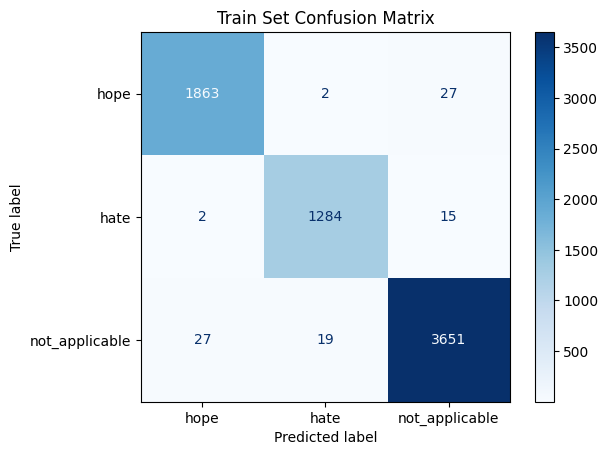

In [ ]:
#  FULL TRAINING
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import json, re, string, nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#    Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#    Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))


#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]



#    Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#    Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

#    Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

#    Training Loop
model.train()
for epoch in range(8):
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {correct/total:.4f}")

#    Evaluate on Train
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#    Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))

#    Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Train Set Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_data/new models/bert_base_new.pt')


📊 Test Set Classification Report:
                precision    recall  f1-score   support

          hope      0.914     0.627     0.744       102
          hate      0.535     0.719     0.613        32
not_applicable      0.749     0.846     0.794       162

      accuracy                          0.757       296
     macro avg      0.733     0.731     0.717       296
  weighted avg      0.783     0.757     0.757       296

🔁 Test Macro F1: 0.7172407594652287
🔁 Macro Accuracy: 0.7567567567567568
🔁 Macro Precision: 0.7326011049991226
🔁 Macro Recall: 0.7306266642459454


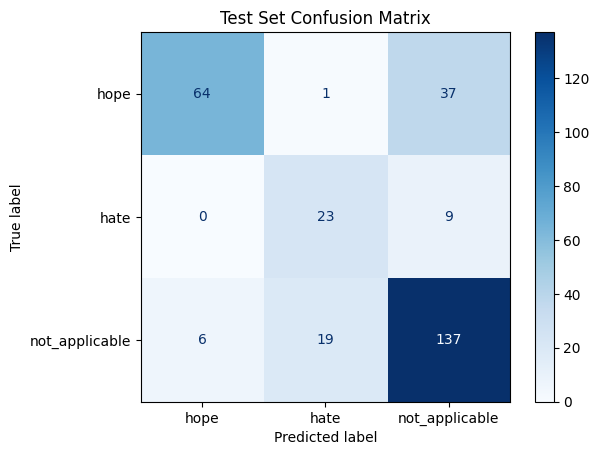

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score


# ✅ Split only for evaluation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenize only test set (train_loader stays same as before)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)
test_dataset = ArabicDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#   Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("\n📊 Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Test Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Test Set Confusion Matrix")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


📊 Evaluation on validation.csv:
                precision    recall  f1-score   support

          hope      0.906     0.609     0.729       509
          hate      0.608     0.804     0.692       158
not_applicable      0.756     0.864     0.806       809

      accuracy                          0.770      1476
     macro avg      0.757     0.759     0.742      1476
  weighted avg      0.792     0.770     0.767      1476

🔁 Macro F1: 0.7422937026478645
🔁 Macro Accuracy: 0.7696476964769647
🔁 Macro Precision: 0.7565879755353441
🔁 Macro Recall: 0.7589548209011228


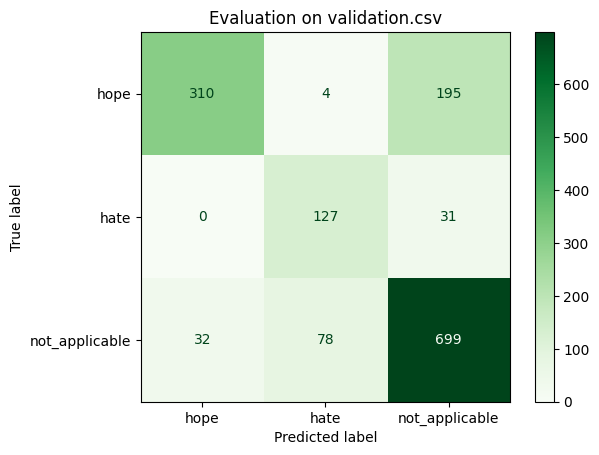

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#   Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["predicted_label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#   Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#   Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#   Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#   Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new.pt", map_location=device), strict=False)
model.eval()

#   Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#   Metrics
print("\n📊 Evaluation on validation.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on validation.csv")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on test.csv:
                precision    recall  f1-score   support

          hope      0.614     0.512     0.558       422
          hate      0.633     0.540     0.583       287
not_applicable      0.640     0.733     0.683       768

      accuracy                          0.632      1477
     macro avg      0.629     0.595     0.608      1477
  weighted avg      0.631     0.632     0.628      1477

🔁 Macro F1: 0.6080329096618268
🔁 Macro Accuracy: 0.6323628977657414
🔁 Macro Precision: 0.628687384044527
🔁 Macro Recall: 0.5949969814366813


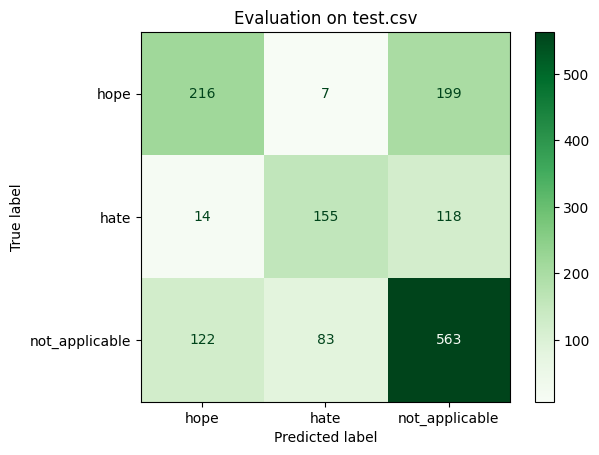

In [ ]:
# This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#   Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#   Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#   Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#   Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#   Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new.pt", map_location=device), strict=False)
model.eval()

#   Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#   Metrics
print("\n📊 Evaluation on test.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on test.csv")
plt.show()


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import json, re, string, nltk

#   Init
nltk.download('stopwords')
from nltk.corpus import stopwords
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   Preprocessing Pipeline (Same as training)
stopwords_arabic = set(stopwords.words('arabic'))

with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))


#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text




#   Step 1: Load Validation Text
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation.csv")  # must have 'text' column
texts_raw = val_df["text"].astype(str).tolist()
# cleaned_texts = full_clean_pipeline(texts_raw)
cleaned_texts = [clean_text(t) for t in texts_raw]

#   Step 2: Tokenizer
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#   Step 3: Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

val_dataset = ArabicDataset(encodings)
val_loader = DataLoader(val_dataset, batch_size=16)

#   Step 4: Load Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new.pt"), strict=False)
model.eval()

#   Step 5: Inference
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

#   Step 6: Save CSV
label_map = {0: "hope", 1: "hate", 2: "not_applicable"}
val_df["predicted_label"] = all_preds
val_df["predicted_label_str"] = val_df["predicted_label"].map(label_map)
val_df.to_csv("validation_with_predictions.csv", index=False)

print("✅ Predictions saved to 'validation_with_predictions.csv'")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Predictions saved to 'validation_with_predictions.csv'


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import json, re, string, nltk

# Init
nltk.download('stopwords')
from nltk.corpus import stopwords
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   Preprocessing Pipeline (Same as training)
stopwords_arabic = set(stopwords.words('arabic'))

with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text




#   Step 1: Load Validation Text
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")  # must have 'text' column
texts_raw = val_df["text"].astype(str).tolist()
# cleaned_texts = full_clean_pipeline(texts_raw)
cleaned_texts = [clean_text(t) for t in texts_raw]

#   Step 2: Tokenizer
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#   Step 3: Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

val_dataset = ArabicDataset(encodings)
val_loader = DataLoader(val_dataset, batch_size=16)

#   Step 4: Load Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new.pt"), strict=False)
model.eval()

#   Step 5: Inference
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

#   Step 6: Save CSV
label_map = {0: "hope", 1: "hate", 2: "not_applicable"}
val_df["predicted_label"] = all_preds
val_df["predicted_label_str"] = val_df["predicted_label"].map(label_map)
val_df.to_csv("test_with_predictions.csv", index=False)

print("✅ Predictions saved to 'test_with_predictions.csv'")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

✅ Predictions saved to 'test_with_predictions.csv'


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import json, re, string, nltk

#   Init
nltk.download('stopwords')
from nltk.corpus import stopwords
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   Preprocessing Pipeline (Same as training)
stopwords_arabic = set(stopwords.words('arabic'))

with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#    Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text




#   Step 1: Load Validation Text
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")  # must have 'text' column
texts_raw = val_df["text"].astype(str).tolist()
# cleaned_texts = full_clean_pipeline(texts_raw)
cleaned_texts = [clean_text(t) for t in texts_raw]

#   Step 2: Tokenizer
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#   Step 3: Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

val_dataset = ArabicDataset(encodings)
val_loader = DataLoader(val_dataset, batch_size=16)

#   Step 4: Load Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert base.pt"), strict=False)
model.eval()

#   Step 5: Inference
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

#   Step 6: Save CSV
label_map = {0: "hope", 1: "hate", 2: "not_applicable"}
val_df["predicted_label"] = all_preds
val_df["predicted_label_str"] = val_df["predicted_label"].map(label_map)
val_df.to_csv("testing_with_predictions.csv", index=False)

print("✅ Predictions saved to 'testing_with_predictions.csv'")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Predictions saved to 'testing_with_predictions.csv'


In [3]:
# github fix
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace 'hope and hate single multiclass classifier.ipynb'

[NbConvertApp] WARNING | pattern 'hope and hate single multiclass classifier.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp